# **INTELIGENCIA ARTIFICIAL** - Modelo Deep Learning para clasificación de imágenes

## Introducción

En este proyecto, desarrollamos un modelo de **Deep Learning** para la clasificación de imágenes de flores con el fin de asistir a botánicos y aficionados en la identificación rápida de especies. Mediante este sistema, buscamos simplificar la clasificación de flores en campo, especialmente en lugares con poca conexión a internet, donde una app offline podría ser clave. Para ello, creamos una **CNN** desde cero y comparamos su desempeño con un **modelo de transfer learning** pre-entrenado, evaluando cuál de los dos métodos ofrece mejores resultados en precisión y eficiencia.


## Objetivos

1.   Implementar una CNN personalizada y entrenarla con un dataset específico.
2.   Ajustar los hiperparámetros y realizar una evaluación de las métricas de precisión, matriz de confusión y F1-Score.
3.   Implementar un modelo de transfer learning utilizando ResNet50.
4.   Comparar los resultados de ambos modelos.




# Punto 1

## Dataset Utilizado
Se va a implementar un dataset de imágenes de distintos tipos de flores. Este dataset contiene el label de cada una de las imágenes para luego poder evaluar el modelo con las métricas correspondientes.
Las distintas categorias son:


1.   Orquídea (orchid)
2.   Rosas (rose)
3.   Girasol (sunflower)
4.   Jazmín (jasmine)
5.   Tulipan (tulip)

El proceso de recolección de datos se basó en fotografiar estas flores (en caso de tenerlas jardines o lugares públicos cercanos y añadiendo otras imagenes extraídas de Google Imagenes, donde se priorizó en este caso que las imagenes elegidas sean claramente reales (es decir, no hechas por alguna inteligencia artificial o ilustradas). También se aseguró de seleccionar imagenes que no tengan filtros tipicos para redes sociales o estén editadas de alguna forma que haga que no parezca una fotografía normal sacada con una camara ordinaria.

Una vez obtenidas 8 imagenes de cada flor, se hizo un proceso de lebelling con LabelImg, donde cada flor fue denotada en una bounding box. El proceso final llevó a dos carpetas, una con las imagenes (en formato jpg o png), dividida en 3 carpetas:
- Carpeta de imagenes de entrenamiento (train).
- Carpeta de imagenes de validación (val).
- Carpeta de imagenes de test (test).

y otra carpeta con los labels (en formato xml) también distribuidas en 3 carpetas (train, val y test). La posición en las carpetas de los labels corresponde a su equivalente en png/jpg en la carpeta de imagenes.

## Preparación del Entorno y Conexión con Google Drive

Conectamos el entorno de Google Colab a Google Drive para acceder al dataset.

In [ ]:
# conectar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga y Exploración del Dataset

Verificamos que el dataset está correctamente organizado en el directorio y que contiene las imágenes y sus etiquetas en el formato adecuado (XML). Esto asegura que el dataset está listo para ser utilizado.

In [ ]:
# printear archivos para ver si esta tomando
dataset_path = '/content/drive/MyDrive/TP IA DATASET'

import os

for root, dirs, files in os.walk(dataset_path):
    print(f"Directorio: {root}")
    for file in files:
        print(f"  Archivo: {file}")

Directorio: /content/drive/MyDrive/TP IA DATASET
Directorio: /content/drive/MyDrive/TP IA DATASET/images
Directorio: /content/drive/MyDrive/TP IA DATASET/images/val
  Archivo: sunflower3.jpg
  Archivo: tulip7.png
  Archivo: tulip4.png
  Archivo: orchid5.png
  Archivo: rose7.jpg
  Archivo: rose4.jpg
  Archivo: jasmine7.jpg
  Archivo: jasmine6.jpg
  Archivo: orchid6.png
  Archivo: sunflower4.jpg
Directorio: /content/drive/MyDrive/TP IA DATASET/images/train
  Archivo: sunflower1.jpg
  Archivo: sunflower2.jpg
  Archivo: sunflower5.jpg
  Archivo: sunflower6.jpg
  Archivo: orchid1.png
  Archivo: orchid2.png
  Archivo: orchid3.png
  Archivo: tulip6.png
  Archivo: tulip8.png
  Archivo: tulip1.png
  Archivo: tulip2.png
  Archivo: tulip3.png
  Archivo: orchid4.png
  Archivo: rose1.jpg
  Archivo: rose3.jpg
  Archivo: rose6.jpg
  Archivo: rose5.jpg
  Archivo: rose2.png
  Archivo: jasmine4.jpg
  Archivo: jasmine3.jpg
  Archivo: jasmine5.png
  Archivo: jasmine2.jpg
  Archivo: jasmine1.png
  Archivo:

In [ ]:
# Ejecutar si `lxml` aún no está instalado.
!pip install lxml

# Punto 2

Se contruirá una Red Neuronal Convolucional (CNN) desde cero para lograr la correcta clasificación de imágenes.

## Importación de Librerías Necesarias

Importamos todas las bibliotecas necesarias, incluyendo PyTorch para el desarrollo de la CNN, PIL para manipulación de imágenes y xml.etree.ElementTree para leer etiquetas en XML.

In [ ]:
# Importamos las bibliotecas necesarias para manejar los datos, crear el modelo, y entrenarlo
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score


from itertools import product
from torch.optim.lr_scheduler import CosineAnnealingLR

## Definición del Dataset Personalizado

Creamos una clase de dataset personalizada que lee imágenes y etiquetas en XML y las asocia correctamente.

In [ ]:
# Definición del Dataset Personalizado para leer Imágenes y Etiquetas en XML
class CustomXMLDataset(Dataset):
    def __init__(self, images_dir, labels_dir, classes, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = []
        self.label_files = []
        self.classes = classes  # Lista de clases en el orden planteado: ["orchid", "rose", "sunflower", "jasmine", "tulip"]

        # Buscamos y almacenamos las rutas de las imágenes y las etiquetas XML correspondientes
        for img_name in os.listdir(images_dir):
            if img_name.endswith(('.jpg', '.png')):
                self.image_files.append(os.path.join(images_dir, img_name))

                # Detectar si el archivo XML tiene la extensión .jpg o .png y ajustar el nombre
                label_base_name = os.path.splitext(img_name)[0]  # Nombre del archivo sin extensión
                label_path_png = os.path.join(labels_dir, label_base_name + '.xml')  # Ruta si la imagen fuera .png
                label_path_jpg = os.path.join(labels_dir, label_base_name + '.xml')  # Ruta si la imagen fuera .jpg

                # Verificar si el archivo XML existe y guardarlo en la lista
                if os.path.exists(label_path_png):
                    self.label_files.append(label_path_png)
                elif os.path.exists(label_path_jpg):
                    self.label_files.append(label_path_jpg)
                else:
                    self.label_files.append(None)  # Agrega None si falta la etiqueta, para depurar más tarde

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Cargar imagen
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")

        # Cargar archivo XML y extraer la etiqueta y las coordenadas del bounding box
        label_path = self.label_files[idx]
        if label_path is None:
            raise FileNotFoundError(f"No se encontró archivo XML para la imagen {image_path}.")

        tree = ET.parse(label_path)
        root = tree.getroot()

        # Tomamos la clase y convertimos el nombre a un índice numérico
        obj = root.find('object')
        class_name = obj.find('name').text
        label = self.classes.index(class_name)  # Índice de clase

        # Aplicamos transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label  # Devuelve la imagen y la etiqueta numérica

## Definición de la Arquitectura de la CNN

Implementamos una CNN con cuatro capas convolucionales, seguidas de capas completamente conectadas para realizar la clasificación. Las capas convolucionales extraen características de las imágenes, mientras que las capas conectadas predicen la clase de cada imagen.

In [ ]:
# Definir la Arquitectura de la CNN con al menos 4 Capas Ocultas
class FloresCNN(nn.Module):
    def __init__(self):
        super(FloresCNN, self).__init__()
        # Capas convolucionales y de pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, len(classes))  # Número de clases

    def forward(self, x):
        # Pasar los datos a través de las capas
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        # Aplanar para la capa totalmente conectada
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Configuración de Transformaciones y DataLoader




Configuramos las transformaciones necesarias para ajustar el tamaño de las imágenes y normalizarlas. Creamos loaders para el conjunto de entrenamiento y de validación para trabajar con lotes.

In [ ]:
# Configuración de las Clases, Transformaciones y DataLoader
classes = ["orchid", "rose", "sunflower", "jasmine", "tulip"]

# Transformaciones para normalizar y ajustar el tamaño de las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Cargar dataset y preparar DataLoader
train_dataset = CustomXMLDataset(
    images_dir='/content/drive/MyDrive/TP IA DATASET/images/train',
    labels_dir='/content/drive/MyDrive/TP IA DATASET/labels/train',
    classes=classes,
    transform=transform
)

val_dataset = CustomXMLDataset(
    images_dir='/content/drive/MyDrive/TP IA DATASET/images/val',
    labels_dir='/content/drive/MyDrive/TP IA DATASET/labels/val',
    classes=classes,
    transform=transform
)

test_dataset = CustomXMLDataset(
    images_dir='/content/drive/MyDrive/TP IA DATASET/images/test',
    labels_dir='/content/drive/MyDrive/TP IA DATASET/labels/test',
    classes=classes,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Configuración del Modelo, Función de Pérdida y Optimizador

Definimos el modelo, la función de pérdida (para clasificación multiclase) y el optimizador, configurados para entrenar la CNN desde cero.

In [ ]:
# 5. Configuración del Modelo, Función de Pérdida, y Optimizador
model = FloresCNN()
criterion = nn.CrossEntropyLoss()  # Función de pérdida de clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam

## Entrenamiento de la CNN

Entrenamos la CNN utilizando los datos de entrenamiento, minimizando la pérdida y ajustando los parámetros de la red a lo largo de las épocas.

In [ ]:
# Entrenamiento del Modelo
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Pasa las imágenes por la red
        loss = criterion(outputs, labels)  # Calcula la pérdida
        loss.backward()  # Calcula los gradientes
        optimizer.step()  # Actualiza los parámetros

        running_loss += loss.item()

    print(f"Época {epoch+1}/{epochs}, Pérdida de entrenamiento: {running_loss/len(train_loader)}")


Época 1/10, Pérdida de entrenamiento: 1.6523645877838136
Época 2/10, Pérdida de entrenamiento: 1.5920593738555908
Época 3/10, Pérdida de entrenamiento: 1.4942196369171143
Época 4/10, Pérdida de entrenamiento: 1.1033348560333252
Época 5/10, Pérdida de entrenamiento: 0.8784286379814148
Época 6/10, Pérdida de entrenamiento: 0.6262710750102997
Época 7/10, Pérdida de entrenamiento: 0.5252411842346192
Época 8/10, Pérdida de entrenamiento: 0.4088356912136078
Época 9/10, Pérdida de entrenamiento: 0.364457780122757
Época 10/10, Pérdida de entrenamiento: 0.1808832511305809


## Evaluación del modelo

Evaluamos el rendimiento del modelo utilizando el conjunto de validación, obteniendo métricas como la precisión.

In [ ]:
# Evaluación del Modelo
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Desactiva el gradiente para evaluación
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular precisión en el conjunto de validación
accuracy = accuracy_score(all_labels, all_preds)
print(f"Precisión en el conjunto de validación: {accuracy * 100:.2f}%")

Precisión en el conjunto de validación: 70.00%


## Búsqueda del Mejor Conjunto de Hiperparámetros

La búsqueda de los hiperparámetros ideales en este caso se llevó a cabo mediante una técnica de búsqueda en cuadrícula (grid search) que evalúa combinaciones de los siguientes parámetros:

**Tasa de aprendizaje** (learning rate). Controla la magnitud de ajuste de los pesos en cada paso de optimización - En este caso se tomaron los siguientes rangos de valores: [0.001, 0.0005]

**Tamaño del lote** (batch size). Tamaños de lote pequeños pueden hacer que el modelo se adapte mejor a los datos, pero incrementan el tiempo de entrenamiento. Tamaños grandes permiten un mejor uso de la memoria y entrenamiento más rápido, y tiende mejor a l generalizacion. - En este caso se tomaron los siguientes rangos de valores: [16, 32]

**Optimizador**. Adam y SGD son técnicas populares para actualizar los pesos. Adam adapta la tasa de aprendizaje automáticamente y suele tener una convergencia más rápida, mientras que SGD suele ser más estable para encontrar soluciones más generalizables - En este caso se tomaron los siguientes rangos de valores: [Adam, SGD]

**Tasa de dropout**. La regularización a través de dropout ayuda a evitar el sobreajuste, desactivando aleatoriamente neuronas durante el entrenamiento para mejorar la robustez - En este caso se tomaron los siguientes rangos de valores:[0.3, 0.6]

**Selección de Hiperparámetros Óptimos**

Al realizar múltiples pruebas, los resultados se evalúan en base a la precisión en el conjunto de validación. Tras las pruebas, el conjunto de hiperparámetros óptimos fue:

Learning rate: 0.001

Batch size: 2

Optimizer: Adam

Dropout rate: 0.4

La combinación óptima de hiperparámetros fue seleccionada al observar el conjunto con la mayor generalización en el conjunto de validación y test.


In [ ]:
# Pruebas de Hiperparámetros
learning_rates = [0.001, 0.0005]
batch_sizes = [2, 5]
optimizers = [optim.Adam, optim.SGD]
dropout_rates = [0.4, 0.6]

best_accuracy = 0
best_hyperparams = {}

for lr, batch_size, opt, dropout in product(learning_rates, batch_sizes, optimizers, dropout_rates):
    print(f"\nProbando con lr={lr}, batch_size={batch_size}, optimizer={opt.__name__}, dropout_rate={dropout}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Modelo con Dropout
    class CNNWithDropout(nn.Module):
        def __init__(self, dropout_rate):
            super(CNNWithDropout, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 512)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(512, len(classes))

        def forward(self, x):
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            x = self.pool(torch.relu(self.conv4(x)))
            x = x.view(-1, 128 * 8 * 8)
            x = self.dropout(torch.relu(self.fc1(x)))
            x = self.fc2(x)
            return x

    model = CNNWithDropout(dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt(model.parameters(), lr=lr)

    # Entrenamiento
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Época {epoch+1}/{epochs}, Pérdida de entrenamiento: {running_loss/len(train_loader)}")

    # Evaluación
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de validación: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'optimizer': opt.__name__,
            'dropout_rate': dropout
        }

print(f"\nMejor precisión obtenida: {best_accuracy * 100:.2f}%")
print("Hiperparámetros óptimos:")
for k, v in best_hyperparams.items():
    print(f"{k}: {v}")

# Mejor Hiperparametro hallado:

# learning_rate: 0.001 batch_size: 16 optimizer: Adam dropout_rate: 0.6


Probando con lr=0.001, batch_size=2, optimizer=Adam, dropout_rate=0.4
Época 1/10, Pérdida de entrenamiento: 1.8258576851624708
Época 2/10, Pérdida de entrenamiento: 1.6145834280894353
Época 3/10, Pérdida de entrenamiento: 1.6067686356030977
Época 4/10, Pérdida de entrenamiento: 1.5254303767130926
Época 5/10, Pérdida de entrenamiento: 1.2022180007054255
Época 6/10, Pérdida de entrenamiento: 0.941877509538944
Época 7/10, Pérdida de entrenamiento: 0.945469201184236
Época 8/10, Pérdida de entrenamiento: 0.7860212956483548
Época 9/10, Pérdida de entrenamiento: 0.8378256106605897
Época 10/10, Pérdida de entrenamiento: 0.86030479047734
Precisión en el conjunto de validación: 70.00%

Probando con lr=0.001, batch_size=2, optimizer=Adam, dropout_rate=0.6
Época 1/10, Pérdida de entrenamiento: 1.6922752582109892
Época 2/10, Pérdida de entrenamiento: 1.6119455924400916
Época 3/10, Pérdida de entrenamiento: 1.616552628003634
Época 4/10, Pérdida de entrenamiento: 1.5274945956010084
Época 5/10, Pérdi

## Evaluación y Pruebas de los Hiperparámetros Óptimos

Con los hiperparámetros óptimos definidos, se entrenó el modelo nuevamente y se implementaron estrategias adicionales de regularización y ajuste fino para maximizar la precisión:

**Scheduler (Cosine Annealing)**: Implementación de un programador de tasas de aprendizaje (CosineAnnealingLR) que ajusta la tasa de aprendizaje de forma gradual, contribuyendo a un ajuste fino hacia el final del entrenamiento.

**Data Augmentation**: Transformaciones aleatorias en el conjunto de entrenamiento, como rotación y volteo horizontal, mejoraron la capacidad del modelo para generalizar, adaptándose mejor a variaciones en las imágenes.

**Proceso de Entrenamiento**
Se entrenó el modelo durante 40 épocas, registrando la pérdida y precisión en cada época. Se guardó el modelo con mejor desempeño, permitiendo una mejora iterativa sobre la precisión alcanzada.

Al finalizar el entrenamiento, se reportó una precisión final en el conjunto de validación que confirmó la eficacia de los hiperparámetros seleccionados.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Definir la Arquitectura de la CNN mejorada
class FloresCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(FloresCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, len(classes))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# 5. Configuración del Modelo, Función de Pérdida y Optimizador
model = FloresCNN(dropout_rate=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 6. Entrenamiento del Modelo
epochs = 40
best_val_accuracy = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}/{epochs}, Pérdida de entrenamiento: {running_loss/len(train_loader):.4f}")

    # Evaluación en el conjunto de validación
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular precisión en el conjunto de validación
    val_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de validación en la época {epoch+1}: {val_accuracy * 100:.2f}%")

    # Guardar el modelo si mejora la precisión
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Modelo mejorado y guardado.")

    # Ajustar la tasa de aprendizaje
    scheduler.step()

print("Entrenamiento finalizado.")
print(f"Mejor precisión en el conjunto de validación: {best_val_accuracy * 100:.2f}%")


Época 1/40, Pérdida de entrenamiento: 1.6512
Precisión en el conjunto de validación en la época 1: 20.00%
Modelo mejorado y guardado.
Época 2/40, Pérdida de entrenamiento: 1.6309
Precisión en el conjunto de validación en la época 2: 20.00%
Época 3/40, Pérdida de entrenamiento: 1.6045
Precisión en el conjunto de validación en la época 3: 20.00%
Época 4/40, Pérdida de entrenamiento: 1.5626
Precisión en el conjunto de validación en la época 4: 50.00%
Modelo mejorado y guardado.
Época 5/40, Pérdida de entrenamiento: 1.1930
Precisión en el conjunto de validación en la época 5: 50.00%
Época 6/40, Pérdida de entrenamiento: 0.9725
Precisión en el conjunto de validación en la época 6: 70.00%
Modelo mejorado y guardado.
Época 7/40, Pérdida de entrenamiento: 0.7980
Precisión en el conjunto de validación en la época 7: 30.00%
Época 8/40, Pérdida de entrenamiento: 0.7506
Precisión en el conjunto de validación en la época 8: 60.00%
Época 9/40, Pérdida de entrenamiento: 0.6165
Precisión en el conjunt

# **Punto 3**

## Evaluación del modelo y explicación de la función de las métricas
Aplicaremos métricas de evaluación al modelo de clasificación ya entrenado, utilizando un conjunto de datos de prueba, y evaluando su rendimiento con Accuracy y F1-Score. Estas métricas nos permitirán medir el desempeño del modelo tanto en términos generales como en situaciones de posibles desbalances de clases.

**¿Por qué elegimos Accuracy y F1-Score?** <br/>
**Accuracy:** Proporciona una visión clara del porcentaje de predicciones correctas, siendo útil cuando las clases están balanceadas o se quiere una visión global del rendimiento.<br/>
**F1-Score:** Es más adecuada para datasets desbalanceados, ya que considera tanto la precisión como el recall, dando una mejor idea del rendimiento en cada clase individual.

In [ ]:
# Evaluación en el conjunto de prueba
model.eval()  # Configurar el modelo en modo evaluación
test_preds = []
test_labels = []

with torch.no_grad():  # Desactiva el cálculo de gradientes para la evaluación
    for images, labels in test_loader:  # test_loader es el DataLoader del conjunto de prueba
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calcular precisión y F1-Score en el conjunto de prueba
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_score = f1_score(test_labels, test_preds, average='weighted')  # Weighted para considerar el balance de clases

print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")
print(f"F1-Score en el conjunto de prueba: {test_f1_score:.2f}")


Precisión en el conjunto de prueba: 80.00%
F1-Score en el conjunto de prueba: 0.73


## Conclusión de la evaluación del modelo
Que accuracy de 80% indica que el modelo clasifica correctamente ese porcentaje de imágenes del conjunto de prueba, lo cual significa que generaliza bien.
<br><br/>
Dado que F1-Score combina precision y recall, que de 0.73 significa que aunque el modelo tenga buena accuracy y un balance entre accuracy y recall aceptable, hay margen de mejora, porque si bien identifica correctamente a la mayoría de instancias positivas, aún puede estar cometiendo algunos errores, ya sea al clasificar falsos positivos o falsos negativos.

# **Punto 4**

## Implementación de Transfer Learning con un Modelo Pre-entrenado

Usamos un modelo pre-entrenado (ResNet50 en este caso) y ajustamos la última capa para adaptarla al número de clases de nuestro dataset. Congelamos las capas pre-entrenadas para que no se modifiquen durante el entrenamiento.

Se eligio este modelo dado que resulta eficiente y equilibrado en términos de complejidad computacional.

Es bastante usado para clasificación de imágenes.

In [ ]:
# Importo un modelo pre-entrenado
from torchvision import models
import torch.nn as nn


In [ ]:
# Cargar el Modelo Pre-entrenado y Ajustar la Capa de Salida
# Cargar ResNet50
model_transfer = models.resnet50(pretrained=True)

# Congelar todas las capas excepto la última para que no se actualicen durante el entrenamiento
for param in model_transfer.parameters():
    param.requires_grad = False

# Cambiar la última capa para que coincida con nuestras clases
num_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_features, len(classes))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Entrenamiento del Modelo de Transfer Learning

In [ ]:
# Configuro el optimizador y la función de perdida
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=0.005)


In [ ]:
# Entreno el modelo
epochs = 10
for epoch in range(epochs):
    model_transfer.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_transfer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}/{epochs}, Pérdida de entrenamiento: {running_loss/len(train_loader):.4f}")


Época 1/10, Pérdida de entrenamiento: 4.9429
Época 2/10, Pérdida de entrenamiento: 4.9669
Época 3/10, Pérdida de entrenamiento: 1.6492
Época 4/10, Pérdida de entrenamiento: 0.9827
Época 5/10, Pérdida de entrenamiento: 1.8455
Época 6/10, Pérdida de entrenamiento: 1.4237
Época 7/10, Pérdida de entrenamiento: 0.9889
Época 8/10, Pérdida de entrenamiento: 0.7698
Época 9/10, Pérdida de entrenamiento: 1.9891
Época 10/10, Pérdida de entrenamiento: 0.2616


##Evaluación del Modelo de Transfer Learning

Evaluamos el rendimiento del modelo de transfer learning en el conjunto de validación y calculamos distintas métricas.

In [ ]:
# Evaluo el modelo
model_transfer.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_transfer(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcular precisión en el conjunto de validación
accuracy = accuracy_score(all_labels, all_preds)
print(f"Precisión en el conjunto de validación del modelo de Transfer Learning: {accuracy * 100:.2f}%")


Precisión en el conjunto de validación del modelo de Transfer Learning: 100.00%


## Comparación de los distintos modelos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar imágenes con etiquetas y predicciones en una cuadrícula
def show_predictions_grid(model, dataloader, classes, num_images=20):
    model.eval()  # Configuramos el modelo en modo evaluación

    images_shown = 0
    plt.figure(figsize=(15, 12))  # Tamaño de la figura

    with torch.no_grad():  # Desactiva el cálculo de gradientes
        for images, labels in dataloader:
            # Pasa las imágenes por el modelo para obtener las predicciones
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Muestra cada imagen con la etiqueta real y la predicción
            for j in range(images.size(0)):
                if images_shown >= num_images:
                    break  # Muestra solo el número deseado de imágenes

                image = images[j].cpu().numpy().transpose((1, 2, 0))
                label = labels[j].item()
                pred = preds[j].item()

                # Determina el color del borde: verde si es correcta, rojo si es incorrecta
                color = 'green' if label == pred else 'red'

                plt.subplot(num_images // 5, 5, images_shown + 1)  # Configura la cuadrícula
                plt.imshow(np.clip(image, 0, 1))
                plt.title(f"Real: {classes[label]}\nPred: {classes[pred]}", color=color)
                plt.axis('off')

                # Agregar un borde de color en la imagen
                plt.gca().spines['top'].set_color(color)
                plt.gca().spines['bottom'].set_color(color)
                plt.gca().spines['left'].set_color(color)
                plt.gca().spines['right'].set_color(color)
                plt.gca().spines['top'].set_linewidth(2)
                plt.gca().spines['bottom'].set_linewidth(2)
                plt.gca().spines['left'].set_linewidth(2)
                plt.gca().spines['right'].set_linewidth(2)

                images_shown += 1

            if images_shown >= num_images:
                break  # Detenemos el bucle después de mostrar el número deseado de imágenes

    plt.tight_layout()
    plt.show()



CNN entrenada desde cero


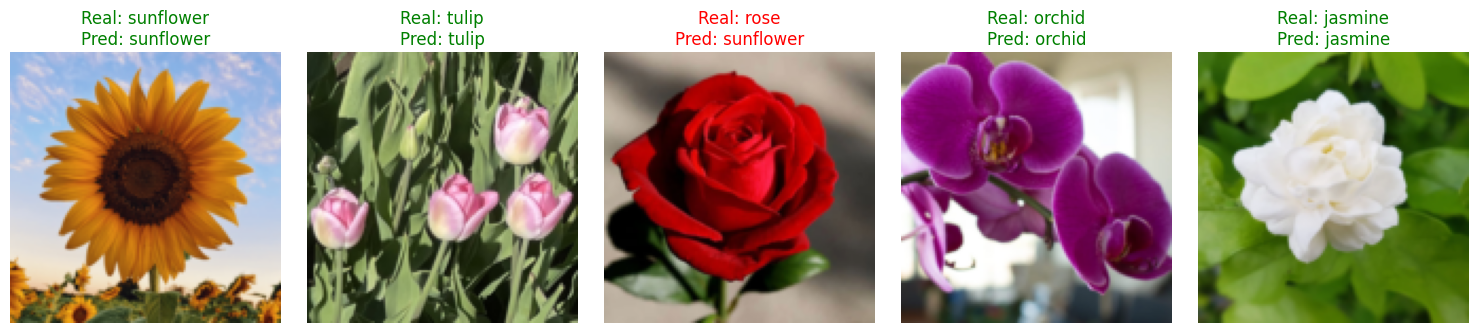

Modelo de transfer learning


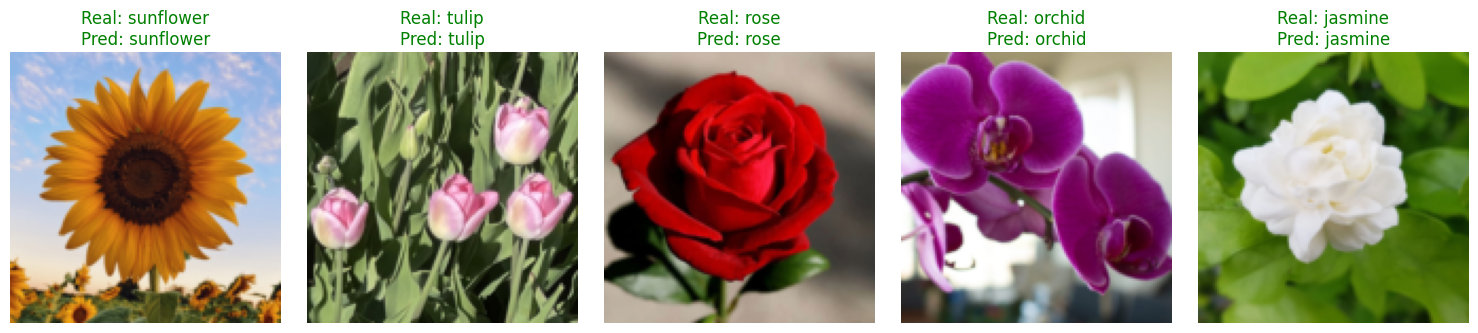

In [ ]:
# Mostrar imágenes, etiquetas verdaderas y predicciones usando la CNN entrenada desde cero
print("CNN entrenada desde cero")
show_predictions_grid(model, test_loader, classes, num_images=20)

# O usando el modelo de transfer learning
print("Modelo de transfer learning")
show_predictions_grid(model_transfer, test_loader, classes, num_images=20)


# Conclusiones

El proyecto demostró con éxito la viabilidad de utilizar técnicas de Deep Learning para la clasificación de imágenes de flores, resaltando la efectividad del enfoque de Transfer Learning con modelos pre-entrenados como ResNet50.

Comparando el modelo pre entrenado, el cual obtuvo un Accuracy del 100%, mientras que la CNN creada desde cero apenas alcanzo el 80% (2 de 5 imágenes clasificadas correctamente).

Se deja en evidencia que el Transfer Learning con modelos pre-entrenados como ResNet50 ofrece una ventaja significativa en tareas de clasificación de imágenes, especialmente cuando se trabaja con datasets limitados y recursos computacionales restringidos.
El porqué detrás de estas ventajas incluyen el conocimiento previo adquirido en grandes conjuntos de datos, arquitecturas optimizadas y la eficiencia en el entrenamiento. Para futuros desarrollos, se recomienda continuar explorando el uso de Transfer Learning, optimizar aún más los modelos pre-entrenados con técnicas como fine-tuning y ampliar el conjunto de datos para potencialmente mejorar aún más la precisión y capacidad de generalización del modelo.

Una dificultad encontrada fue la falta de casos (imágenes) suficientes para lograr un mayor entrenamiento y poder calcular las métricas sobre mayor cantidad de datos de test. Si se agregaran nuevas imágener, podria volverse a entrenar la CNN, esperando observar mejoras en el entrenamiento.